In [5]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

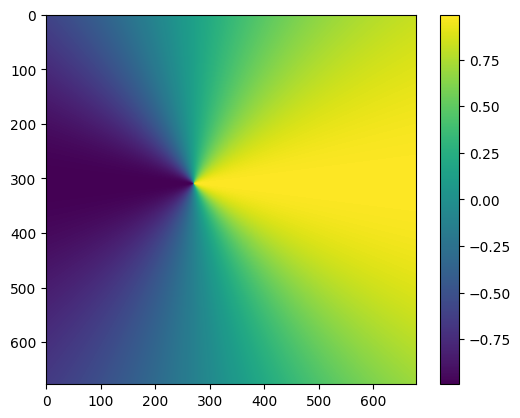

In [6]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()


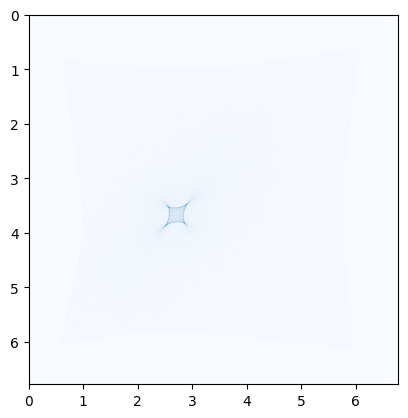

In [7]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
plt.gca().invert_yaxis()

In [8]:
beta = (270.8,355.5) #in pixel
z_s = 1.0
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale, diff_z = False)


Image 1 position: [2.36449748 4.52249827]
Predicted Image 1 position: [2.36449123 4.52250201]
Difference: 7.283400498583839e-06
Image 2 position: [2.55607442 2.60440964]
Predicted Image 2 position: [2.55604283 2.60436845]
Difference: 5.191049399324547e-05


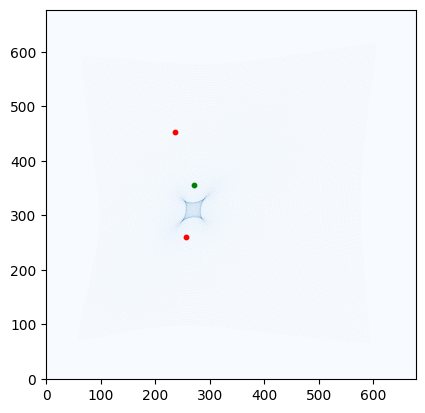

In [9]:


# lenstronomy
solver = LensEquationSolver(lensModel)
thetax, thetay = solver.image_position_analytical(beta[0], beta[1], kwargs_lens)

theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i], thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical * pixscale, key=lambda x: x[0])  # sort by x coordinate

# my class
theta_numerical = np.array(cluster.get_image_positions())
sorted_theta_numerical = sorted(theta_numerical, key=lambda x: x[0])  # sort by x coordinate
plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
plt.scatter(thetax, thetay, color='red', s=10)
plt.scatter(beta[0], beta[1], color='green', s=10)
plt.imshow(array_test, cmap='Blues')
plt.gca().invert_yaxis()


for i in range(len(sorted_theta_analytical)):
    print(f'Image {i+1} position: {sorted_theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    print(f'Difference: {np.sqrt((sorted_theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (sorted_theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')   


In [10]:


print("Numerical:")
mag_table = cluster.get_magnifications() #output a dataframe
print(mag_table)

# Analytical magnifications
data_analytical = []
print("Analytical:")
for i in range(len(thetax)):
    x, y = thetax[i], thetay[i]
    mag = lensModel.magnification(thetax[i], thetay[i], kwargs_lens)
    data_analytical.append({'x': x * pixscale, 'y': y * pixscale, 'magnification': mag})
    

table_analytical = pd.DataFrame(data_analytical)
pd.options.display.float_format = '{:.12f}'.format
table_analytical = table_analytical.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table_analytical)

Numerical:
               x              y   magnification
0 2.364497481512 4.522498268118  2.546449683205
1 2.556074421188 2.604409638373 -0.917488230604
Analytical:
               x              y   magnification
0 2.364491232769 4.522502010026  2.546436813840
1 2.556042827508 2.604368449292 -0.918080408949


In [11]:
# default time delay
print("Numerical:")
dt = cluster.get_time_delays()
print(dt)


'''data_dt = []
for i in range(len(theta_numerical)):
    x, y = theta_numerical[i]
    delay = dt[i]       # in days
    data_dt.append({'x': x, 'y': y, 'delta_t': delay})

table = pd.DataFrame(data_dt)
pd.options.display.float_format = '{:.12f}'.format
table = table.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table)'''


# restore the lens model in arcsec
kwargs_sie1 = {'theta_E': theta_E * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0] * pixscale, 'center_y': len_coord[1] * pixscale}

kwargs_lens1 = [kwargs_sie1]


lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
thetax, thetay = solver.image_position_analytical(beta[0]* pixscale, beta[1]*pixscale, kwargs_lens1)
t_analytical = lensModel.arrival_time(thetax , thetay , kwargs_lens1, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - t_analytical[0]

data_dt_analytical = []
for i in range(len(thetax)):
    x, y = theta_analytical[i] * pixscale
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)

Numerical:
         theta_x        theta_y       d_fermat    delta_t(days)
0 2.364497481495 4.522498268113 0.000000000000   0.000000000000
1 2.556074421167 2.604409638329 0.934834351695 115.410411715436
Analytical:
         theta_x        theta_y          delta_t
0 2.364491232769 4.522502010026   0.000000000000
1 2.556042827508 2.604368449292 119.380039703216


In [12]:
#test multiple source plane lensing code
# assume the default lens and source position are z_l = 0.5, z_s = 1.0 and thete_E = 1.0
z_l = 0.5
z_s = 2.0

#numerical stuffs
cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale, diff_z = True)
print("Numerical:")
dt = cluster_mp.get_time_delays()
print(dt)

# analytical stuffs
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(H0=70, Om0=0.3)

D_S1 = cosmos.angular_diameter_distance(1.0)
D_S2 = cosmos.angular_diameter_distance(z_s)
D_LS1 = cosmos.angular_diameter_distance_z1z2(z_l, 1.0)
D_LS2 = cosmos.angular_diameter_distance_z1z2(z_l, z_s)
factor =  D_LS1 * D_S2 / D_S1 / D_LS2
kwargs_sie2 = {'theta_E': theta_E*factor * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens_mp = [kwargs_sie2]
lensModel2 = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
solver2 = LensEquationSolver(lensModel2)

print("Analytical:")

thetax, thetay = solver2.image_position_analytical(beta[0]* pixscale, beta[1]* pixscale, kwargs_lens_mp)
t_analytical = lensModel2.arrival_time(thetax, thetay, kwargs_lens_mp, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
min_t = min(t_analytical)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - min_t
data_dt_analytical = []
for i in range(len(thetax)):
    x, y = thetax[i] , thetay[i]
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)



Numerical:
         theta_x        theta_y            d_fermat   delta_t(days)
0 2.517717002942 4.215471237479                 0.0  0.000000000000
1 2.658285341652 2.901070635985  0.6180562243963272 51.439735236142
Analytical:
         theta_x        theta_y         delta_t
0 2.517714490209 4.215475133211  0.000000000000
1 2.658248416599 2.900956619547 53.188943216454


In [13]:
# population of time delays
# test the time delay population
import numpy as np

def generate_random_coordinates(num_points, x_bound, y_bound):
    """
    Generate a list of 2-element arrays containing random coordinates within the specified bounds.

    Parameters:
    ---------------
    num_points: int
        The number of random points to generate.
    x_bound: tuple
        A tuple specifying the (min, max) bounds for the x coordinates.
    y_bound: tuple
        A tuple specifying the (min, max) bounds for the y coordinates.

    Returns:
    ---------------
    List of 2-element arrays containing random coordinates.
    """
    x_coords = np.random.uniform(x_bound[0], x_bound[1], num_points)
    y_coords = np.random.uniform(y_bound[0], y_bound[1], num_points)
    coordinates = np.column_stack((x_coords, y_coords))
    return coordinates

# generate beta population in arcsec
num_points = 15000
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
z_l = 0.5
z_s = 1.0
beta_pop = generate_random_coordinates(num_points, x_bound, y_bound)

dt_pop = []
for i in tqdm(range(num_points)):
    beta = beta_pop[i]
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta[0], beta[1], diff_z = False)
    dt = cluster_mp.get_time_delays()
    dt_value = dt['delta_t(days)'].values.tolist()
    dt_value = [value for value in dt_value if value != 0]
    dt_pop.append(dt_value)
    #print(dt['delta_t(days)'])
print(dt_pop)

 43%|████▎     | 6412/15000 [2:11:34<2:56:13,  1.23s/it]   


KeyboardInterrupt: 

Text(0, 0.5, 'Frequency')

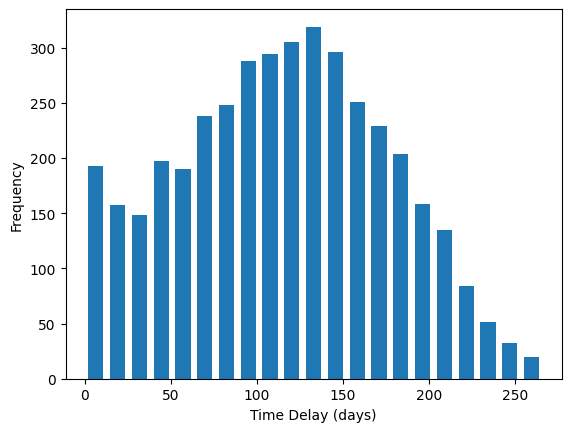

In [68]:
dt_pop_hist = np.concatenate(dt_pop)
delays = dt_pop_hist
def freedman_diaconis_rule(data):
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * iqr * len(data)**(-1/3)
    return int(np.ceil((np.max(data) - np.min(data)) / bin_width))

n_bins = freedman_diaconis_rule(delays)
plt.hist(delays, bins=21,rwidth=0.7)
plt.xlabel('Time Delay (days)')
plt.ylabel('Frequency')

In [18]:
# comparing speed 
import time
start = time.time()
thetax, thetay = solver.image_position_analytical(beta[0]* pixscale, beta[1]*pixscale, kwargs_lens1)
t_analytical = lensModel.arrival_time(thetax , thetay , kwargs_lens1, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
min_t = min(t_analytical)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - min_t
end = time.time()
print("Numerical time:", end - start)

Numerical time: 0.003016233444213867


In [30]:
beta_test = (2.75706612, 3.13571632)
z_l = 0.5
z_s = 1.0
test = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, beta_test[0], beta_test[1], diff_z = False)
print(test.get_time_delays())

         theta_x        theta_y       d_fermat   delta_t(days)
0 3.631838551006 2.558346382515 0.000000000000  0.000000000000
1 2.205921594261 4.025102408389 0.030883330426  3.812715988775
2 3.351753573730 3.840494133003 0.094297006090 11.641480949704
3 2.070870657946 2.520391392420 0.214983536781 26.540892990185
